In [ ]:
!pip install einops
!pwd
!unzip /content/drive/MyDrive/Colab\ Notebooks/archive.zip -d /content/
!pip install timm

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/097.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/098.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/099.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/100.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/101.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/102.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/103.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/104.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/105.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/106.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/107.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/108.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/109.jpg  
  inflating: /content/birds_rev2/train/TOWNSENDS WARBLER/110.jpg  
  inflating: /content/bird

# Vit

NLP에 Transformer를 적용했었지만, computer vision에도 Trnasformer를 적용해본 논문이다.

![1](/content/img/1.PNG)

코드는 

https://github.com/FrancescoSaverioZuppichini/ViT

를 참고하였다.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
import torchvision.transforms as transforms
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

import numpy as np
import pandas as pd
import timm
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

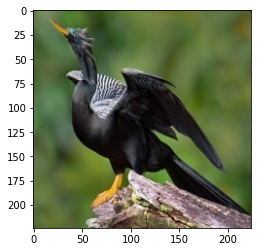

In [ ]:
img = Image.open('/content/birds/train/ANHINGA/001.jpg')

fig = plt.figure()
plt.imshow(img)

In [ ]:
transform = Compose([Resize((224,224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) #batch, c, h, w
x.shape

torch.Size([1, 3, 224, 224])

# Pathces Embeddings

 BATCH x C x H x W 를 BATCH x N x (P x P x C) 로 임베딩 해주어야 한다.

 P는 패치사이즈 이고, N은 패치의 개수이다.

 N은 (H x W) / (P x P) 이다.

 일자로 피기 때문에, Convolution 처럼 주변 pixel 간의 정보를 알 수 있다.



 # CLS

 Bert처럼 cls 토큰을 이용한다.

 
# Position Embbeding






In [ ]:
patch_size = 16
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels : int = 3, patch_size : int = 16, emb_size : int = 168, img_size: int=224):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Sequential(
        #위 처럼 rearrange한 후에, linear로 emb_size만큼의 크기를 줄이는 것보단,
        #Convolution을 이용하는 것이 성능향상에 도움이 된다고 한다.
        nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e'),
    )

    #bert처럼 cls 토큰을 이용한다.
    self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
    self.positions = nn.Parameter(torch.randn((img_size//patch_size)**2 + 1, emb_size))

  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.proj(x)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)

    x = torch.cat([cls_tokens, x], dim=1)
    x+= self.positions
    return x

PatchEmbedding()(x).shape
    

torch.Size([1, 197, 168])

# Transformer

기존의 Transformer와 비슷하다.

좀 다른 점은, Encoder만 있다.

rearrange 부분이 좀 많이 헷갈린다...

[

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size : int = 168, num_heads: int = 8, dropout: float = 0.):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads

    # q, k, v
    self.qkv = nn.Linear(emb_size, emb_size*3)
    self.att_drop = nn.Dropout(dropout)
    self.proj = nn.Linear(emb_size, emb_size)

    
  def forward(self, x: Tensor, mask: Tensor = None):
    qkv = rearrange(self.qkv(x), 'b n (h d qkv) -> (qkv) b h n d', h=self.num_heads, qkv=3)
    q,k,v = qkv[0], qkv[1], qkv[2]

    energy = torch.einsum('bhqd, bhkd -> bhqk',q,k)
    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      energy.mask_fill(~mask, fill_value)

    scailing = self.emb_size**(1/2)
    attention = F.softmax(energy, dim=-1) / scailing
    attention = self.att_drop(attention)

      
    out = torch.einsum('bhal, bhlv -> bhav', attention, v)
    out = rearrange(out, 'b h n d -> b n (h d)')
    out = self.proj(out)

    return out

patch_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patch_embedded).shape




torch.Size([1, 197, 168])

In [ ]:
class Residual(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x +=res
    return x

class FeedForwardBlock(nn.Sequential):
  def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
    super().__init__(
        nn.Linear(emb_size, expansion*emb_size),
        nn.GELU(),
        nn.Dropout(drop_p),
        nn.Linear(expansion * emb_size, emb_size),
    )

class TransformerEncoderBlock(nn.Sequential):
  def __init__(self, emb_size : int = 168, drop_p : float = 0., forward_expansion: int = 4, forward_drop_p: float = 0., **kwargs):
    super().__init__(
        Residual(nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size, **kwargs),
            nn.Dropout(drop_p)
        )),
        Residual(nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
            nn.Dropout(drop_p)
        ))
    )

patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patch_embedded).shape

torch.Size([1, 197, 168])

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [ ]:
class Head(nn.Sequential):
  def __init__(self, emb_size: int = 168 ,n_classes :int=275):
    super().__init__(
        Reduce('b n e -> b e', reduction='mean'),
        nn.LayerNorm(emb_size),
        nn.Linear(emb_size, n_classes)
    )

In [ ]:
class Vit16(nn.Sequential):
  def __init__(self, in_channels : int=3, patch_size : int = 16, emb_size: int=168, img_size : int=224, depth: int=12, n_classes: int = 275, **kwargs):
    super().__init__(PatchEmbedding(in_channels, patch_size, emb_size, img_size),
        TransformerEncoder(depth, emb_size=emb_size, **kwargs),
        Head(emb_size, n_classes))

        


# Pretraining

kaggle의 bird dataset을 이용하여 학습을 해볼 것이다.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, imgs, labels, transforms=None):
    super().__init__()
    self.imgs = imgs
    self.labels = labels
    self.transforms = transforms
  
  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img, label = self.imgs[idx], self.labels[idx]
    img = Image.open(img).convert('RGB')

    if self.transforms is not None:
      img = self.transforms(img)
    
    return img, label
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


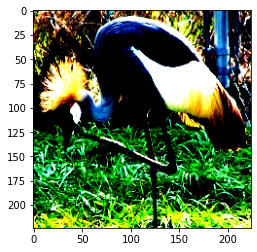

In [ ]:
DATA_PATH = '/content/birds'
df = pd.read_csv(DATA_PATH+'/birds.csv')

str_labels = df['labels'].unique()
labels = [i for i in range(len(str_labels))]

train_df = df[(df['data set'] == 'train')]
train_path = [DATA_PATH+'/'+ (i.replace('\\', '/')) for i in train_df['filepaths']]
train_labels = [np.where(str_labels == s)[0][0] for s in train_df['labels']]

test_df = df[(df['data set'] == 'test')]
test_path = [DATA_PATH+'/' + (i.replace('\\', '/')) for i in test_df['filepaths']]
test_labels = [np.where(str_labels==s)[0][0] for s in test_df['labels']]


train_transformers = transforms.Compose([
 transforms.Resize((224,224)),
 transforms.RandomHorizontalFlip(p=0.3),
 transforms.RandomVerticalFlip(p=0.3),
 transforms.ToTensor(),
 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transformers = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_data = MyDataset(train_path, train_labels, train_transformers)
test_data = MyDataset(test_path, test_labels, test_transformers)


plt.imshow(train_data[0][0].permute(1,2,0))
plt.show()

In [ ]:
def fit(model, epochs, device, criterion, optimizer, train_loader, test_loader):
  train_losses = []
  test_losses = []
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    print(f"{'='*50}")
    print(f"EPOCH {epoch} - TRAINING...")
    train_loss, train_acc = 0.0, 0.0

    model.train()
    for i, (data, target) in enumerate(train_loader):
      data = data.float().to(device)
      target = target.long().to(device)

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      accuracy = (output.argmax(dim=1) == target).float().mean()
      train_loss += loss
      train_acc += accuracy
      print('\tBATCH {}/{} - LOSS: {}'.format(i+1, len(train_loader), loss))
      optimizer.step()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)    
        
    print(f"\t\n[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        

    if test_loader is not None:
            
      print(f"EPOCH {epoch} - TESTING...")
      test_loss, test_acc = 0.0, 0.0
      
      model.eval()
      for data, target in test_loader:
        data = data.float().to(device)
        target = target.long().to(device)

        with torch.no_grad():
          output = model(data)
          loss = criterion(output, target)
          accuracy = (output.argmax(dim=1)==target).float().mean()
          test_loss += loss
          test_acc += accuracy

      test_loss /= len(test_loader)
      test_acc /= len(test_loader)

      print(f"\t[TEST] LOSS: {test_loss}, ACCURACY: {test_acc}\n")
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  return {
    "train_loss": train_losses,
    "test_losses": test_losses,
    "train_acc": train_accs,
    "test_acc": test_accs,
  }

def run(model):
  train_dataset = MyDataset(train_path, train_labels, train_transformers)
  test_dataset = MyDataset(test_path, test_labels, test_transformers)

  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, num_workers=4)
  test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, num_workers=4)

  criterion = nn.CrossEntropyLoss()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=2e-05)

  logs = fit(model=model, epochs = 10, device=device, criterion=criterion, optimizer=optimizer,train_loader=train_loader,test_loader=test_loader)


model = Vit16()
run(model)

EPOCH 0 - TRAINING...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
	BATCH 615/616 - LOSS: 5.928343772888184
	BATCH 616/616 - LOSS: 5.6902055740356445
	
[TRAIN] EPOCH 1 - LOSS: 5.776404857635498, ACCURACY: 0.0004819399327971041

EPOCH 1 - TESTING...
	[TEST] LOSS: 5.613062381744385, ACCURACY: 0.007102272938936949

EPOCH 2 - TRAINING...
	BATCH 1/616 - LOSS: 5.712110996246338
	BATCH 2/616 - LOSS: 5.701844215393066
	BATCH 3/616 - LOSS: 5.218181610107422
	BATCH 4/616 - LOSS: 5.095247268676758
	BATCH 5/616 - LOSS: 5.528728008270264
	BATCH 6/616 - LOSS: 5.835236549377441
	BATCH 7/616 - LOSS: 6.154327869415283
	BATCH 8/616 - LOSS: 6.345296859741211
	BATCH 9/616 - LOSS: 6.237316131591797
	BATCH 10/616 - LOSS: 5.586057186126709
	BATCH 11/616 - LOSS: 5.522602558135986
	BATCH 12/616 - LOSS: 5.696604251861572
	BATCH 13/616 - LOSS: 6.167210102081299
	BATCH 14/616 - LOSS: 6.23200798034668
	BATCH 15/616 - LOSS: 5.91682767868042
	BATCH 16/616 - LOSS: 5.6973981857299805
	BATCH 17/616 - LOSS: 5.7101922035217285
	BATCH 18/616 - LOSS: 5.

# fine tuning

imagenet 2012를 통해서 미리 학습한 모델을 불러와서 사용한다.

In [65]:
class FineVit16(nn.Module):
  def __init__(self, n_classes = 275):
    super().__init__()

    self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
    self.model.head = nn.Linear(self.model.head.in_features, n_classes)

  def forward(self, x):
    out = self.model(x)
    return out

model = FineVit16()
run(model)


EPOCH 0 - TRAINING...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
	BATCH 615/616 - LOSS: 6.936496257781982
	BATCH 616/616 - LOSS: 6.530128002166748
	
[TRAIN] EPOCH 1 - LOSS: 6.0698347091674805, ACCURACY: 0.0010907062096521258

EPOCH 1 - TESTING...
	[TEST] LOSS: 6.5798749923706055, ACCURACY: 0.0035511364694684744

EPOCH 2 - TRAINING...
	BATCH 1/616 - LOSS: 5.948055267333984
	BATCH 2/616 - LOSS: 5.747491359710693
	BATCH 3/616 - LOSS: 5.67282247543335
	BATCH 4/616 - LOSS: 5.495050430297852
	BATCH 5/616 - LOSS: 5.8521599769592285
	BATCH 6/616 - LOSS: 6.046894550323486
	BATCH 7/616 - LOSS: 5.312432289123535
	BATCH 8/616 - LOSS: 4.914047718048096
	BATCH 9/616 - LOSS: 4.695305347442627
	BATCH 10/616 - LOSS: 7.1886162757873535
	BATCH 11/616 - LOSS: 7.010009765625
	BATCH 12/616 - LOSS: 6.710593223571777
	BATCH 13/616 - LOSS: 6.724752426147461
	BATCH 14/616 - LOSS: 6.531000137329102
	BATCH 15/616 - LOSS: 6.0295233726501465
	BATCH 16/616 - LOSS: 5.770181655883789
	BATCH 17/616 - LOSS: 5.531386852264404
	BATCH 18/616 - LOSS: 5

공부 목적으로 구현하려고 했는데, 데이터셋을 좀 잘못 구한 것 같다. 

데이터의 class가 많고, 데이터양이 많다보니 적은 epoch으로는 학습이 잘 안되었다.

결과를 보고 pretrain 이랑 finetuning을 비교해보려 했는데 좀 아쉬웠다.